In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import warnings
import sys

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk

nltk.download('stopwords', quiet=True)
warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED)

In [12]:
# Load the datasets
train_df = pd.read_excel("../Datasets/Train.xlsx")
test_df  = pd.read_excel("../Datasets/Test.xlsx")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
print(train_df["Expected Operation by Developer"].value_counts())

Train shape: (931, 2)
Test  shape: (234, 2)
Expected Operation by Developer
insert     322
delete     309
replace    300
Name: count, dtype: int64


In [13]:
# Train-validation split
X = train_df["Review Comment"]
y = train_df["Expected Operation by Developer"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=SEED, stratify=y
)

print("Train size:", len(X_train), "   Val size:", len(X_val))

Train size: 837    Val size: 94


In [14]:
# Define the base pipeline for Logistic Regression
base_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1,2),     # 1–2-gram
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        solver="saga",
        multi_class="multinomial",
        n_jobs=-1,
        random_state=SEED
    ))
])

In [15]:
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 3],
    "clf__C": [0.1, 1, 5, 10]
}

search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1
)
search.fit(X_train, y_train)

print("Best CV-accuracy:", search.best_score_)
print("Best params:", search.best_params_)
best_pipeline = search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/

Best CV-accuracy: 0.5651411462788709
Best params: {'clf__C': 5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/

In [16]:
final_model = best_pipeline if 'best_pipeline' in globals() else base_pipeline
final_model.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf',
                 LogisticRegression(C=5, max_iter=1000,
                                    multi_class='multinomial', n_jobs=-1,
                                    random_state=42, solver='saga'))])

Test accuracy: 0.6538

Classification report:
               precision    recall  f1-score   support

      delete       0.66      0.58      0.62        78
      insert       0.62      0.72      0.66        81
     replace       0.69      0.67      0.68        75

    accuracy                           0.65       234
   macro avg       0.66      0.65      0.65       234
weighted avg       0.66      0.65      0.65       234



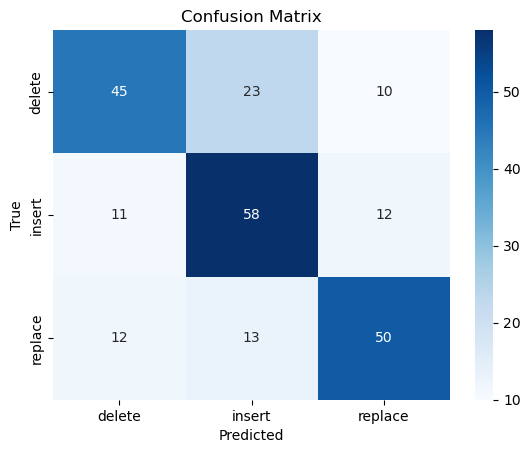

In [17]:
X_test  = test_df["Review Comment"]
y_test  = test_df["Expected Operation by Developer"]

y_pred  = final_model.predict(X_test)
acc     = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {acc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))

# Confusion matrix heat-map
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [18]:
def show_top_weights(model, vectorizer, n=15):
    clf     = model.named_steps["clf"]
    tfidf   = model.named_steps["tfidf"]
    classes = clf.classes_

    feature_names = np.array(tfidf.get_feature_names_out())
    for i, c in enumerate(classes):
        top = np.argsort(clf.coef_[i])[-n:]
        print(f"\nClass '{c}' top terms:")
        print(", ".join(feature_names[top]))

show_top_weights(final_model, final_model.named_steps["tfidf"])



Class 'delete' top terms:
dead, space prohibited, point, don, ifs, use space, prohibited, long, 80, whitespace, removed, extra, need, needed, remove

Class 'insert' top terms:
add comment, uintptr_t file, guess, commenting, id, just line, leave, missing, tab needed, indention, space, static, use, align, add

Class 'replace' top terms:
size, different, uintptr_t, lpc_gen1_dec, update, field, better, value, shouldn, capitalize, just, units, previous, struct, instead
